# Logistic Regression Analysis - Energy Efficiency Classification

This notebook demonstrates logistic regression for classifying energy efficiency levels based on building characteristics.

In [1]:
# Import necessary libraries for logistic regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('default')
sns.set_palette("husl")

## Step 1: Load and Prepare Data for Classification

In [3]:
# Load the energy efficiency dataset
file_path = r"D:\5th Sem\ML\DATASET\energy+efficiency\ENB2012_data.csv"
data = pd.read_csv(file_path)

# Display basic information about the dataset
print("Dataset Information:")
print(f"Shape: {data.shape}")
print(f"Columns: {data.columns.tolist()}")

# If column names need renaming
if 'X1' in data.columns:
    data.columns = [
        'Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 
        'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution',
        'Heating_Load', 'Cooling_Load'
    ]

print(f"\nUpdated columns: {data.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(data.head())

# Check for missing values
print(f"\nMissing values: {data.isnull().sum().sum()}")

Dataset Information:
Shape: (1296, 10)
Columns: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'Y1', 'Y2']

Updated columns: ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load']

First 5 rows:
   Relative_Compactness  Surface_Area  Wall_Area  Roof_Area  Overall_Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   

   Orientation  Glazing_Area  Glazing_Area_Distribution  Heating_Load  \
0          2.0           0.0                        0.0         15.55   
1          3.0           0.0                        0.0     

## Step 2: Convert Continuous Target to Classification Problem

Heating Load Statistics:
Mean: 22.31
Median: 18.95
Min: 6.01
Max: 43.10

Binary Classification Distribution:
High Heating Load (1): 384
Low Heating Load (0): 912
Percentage High: 29.6%

Multi-class Classification Distribution:
Heating_Category
Medium    260
Low       254
High      254
Name: count, dtype: int64


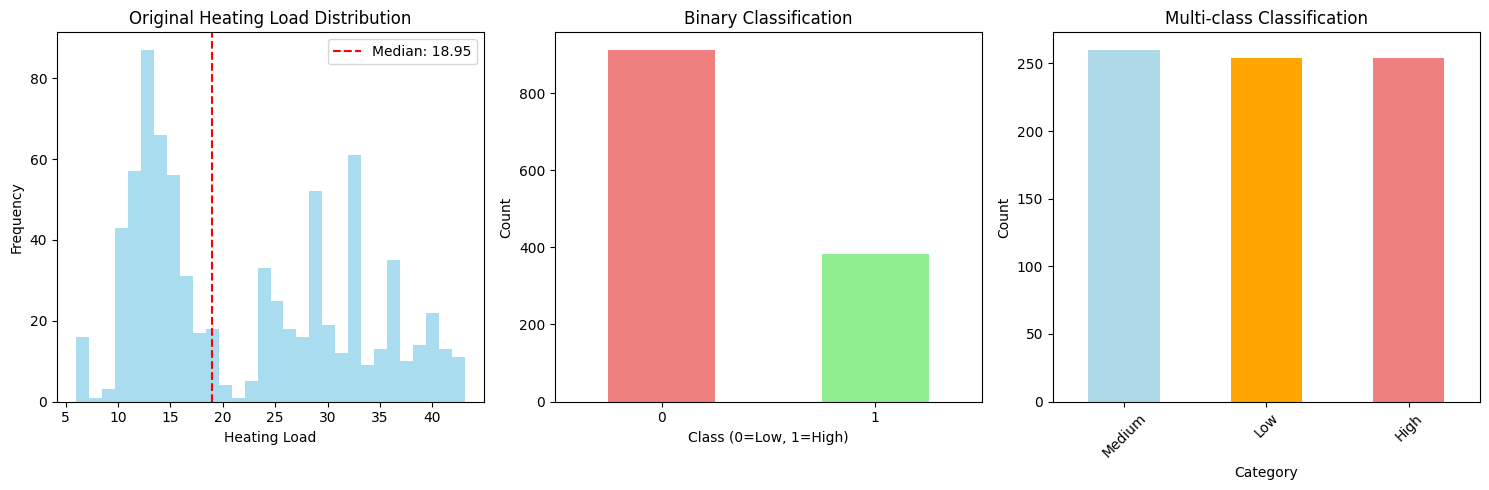

In [4]:
# Convert heating load to binary classification problem
# We'll create different classification scenarios

# Scenario 1: High vs Low Heating Load (Binary Classification)
median_heating = data['Heating_Load'].median()
data['High_Heating_Load'] = (data['Heating_Load'] > median_heating).astype(int)

print(f"Heating Load Statistics:")
print(f"Mean: {data['Heating_Load'].mean():.2f}")
print(f"Median: {median_heating:.2f}")
print(f"Min: {data['Heating_Load'].min():.2f}")
print(f"Max: {data['Heating_Load'].max():.2f}")

print(f"\nBinary Classification Distribution:")
print(f"High Heating Load (1): {data['High_Heating_Load'].sum()}")
print(f"Low Heating Load (0): {len(data) - data['High_Heating_Load'].sum()}")
print(f"Percentage High: {data['High_Heating_Load'].mean()*100:.1f}%")

# Scenario 2: Multi-class Classification (Low, Medium, High)
# Create tertiles for 3-class classification
tertiles = data['Heating_Load'].quantile([0.33, 0.67]).values
data['Heating_Category'] = pd.cut(data['Heating_Load'], 
                                  bins=[-np.inf, tertiles[0], tertiles[1], np.inf], 
                                  labels=['Low', 'Medium', 'High'])

print(f"\nMulti-class Classification Distribution:")
print(data['Heating_Category'].value_counts())

# Visualize the classification targets
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original distribution
axes[0].hist(data['Heating_Load'], bins=30, alpha=0.7, color='skyblue')
axes[0].set_title('Original Heating Load Distribution')
axes[0].set_xlabel('Heating Load')
axes[0].set_ylabel('Frequency')
axes[0].axvline(median_heating, color='red', linestyle='--', label=f'Median: {median_heating:.2f}')
axes[0].legend()

# Binary classification
data['High_Heating_Load'].value_counts().plot(kind='bar', ax=axes[1], color=['lightcoral', 'lightgreen'])
axes[1].set_title('Binary Classification')
axes[1].set_xlabel('Class (0=Low, 1=High)')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

# Multi-class classification
data['Heating_Category'].value_counts().plot(kind='bar', ax=axes[2], color=['lightblue', 'orange', 'lightcoral'])
axes[2].set_title('Multi-class Classification')
axes[2].set_xlabel('Category')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Step 3: Prepare Features for Logistic Regression

Feature Matrix Shape: (1296, 8)
Binary Target Shape: (1296,)
Multi-class Target Shape: (1296,)

Feature scaling completed
Original feature means: [0.76, 671.71, 318.5, 176.6, 5.25, 3.5, 0.23, 2.81]
Scaled feature means: [-0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


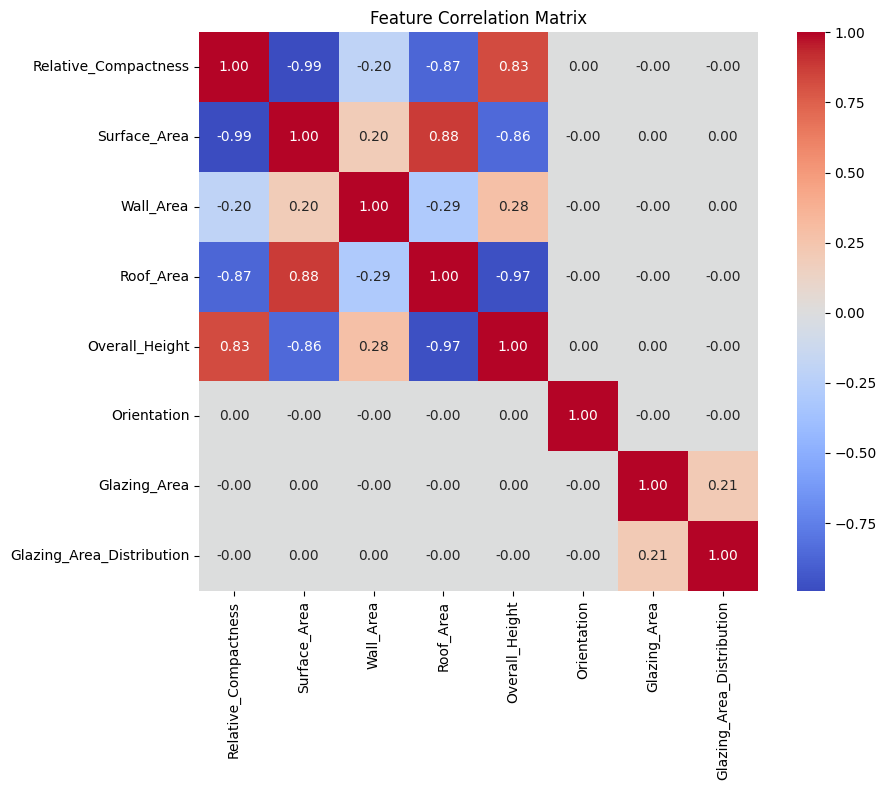

In [5]:
# Define features (exclude target variables)
feature_columns = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 
                   'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution']

X = data[feature_columns]
y_binary = data['High_Heating_Load']
y_multiclass = data['Heating_Category']

print("Feature Matrix Shape:", X.shape)
print("Binary Target Shape:", y_binary.shape)
print("Multi-class Target Shape:", y_multiclass.shape)

# Feature scaling (important for logistic regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"\nFeature scaling completed")
print(f"Original feature means: {X.mean().round(2).tolist()}")
print(f"Scaled feature means: {X_scaled.mean().round(2).tolist()}")

# Check feature correlations
plt.figure(figsize=(10, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## Step 4: Binary Logistic Regression Analysis

In [6]:
# Binary Classification: High vs Low Heating Load
print("=== BINARY LOGISTIC REGRESSION ANALYSIS ===")

# Split the data for binary classification
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_scaled, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print(f"Training set: {X_train_bin.shape[0]} samples")
print(f"Test set: {X_test_bin.shape[0]} samples")
print(f"Training class distribution: {y_train_bin.value_counts().tolist()}")
print(f"Test class distribution: {y_test_bin.value_counts().tolist()}")

# Fit binary logistic regression model
binary_model = LogisticRegression(random_state=42, max_iter=1000)
binary_model.fit(X_train_bin, y_train_bin)

# Make predictions
y_train_pred_bin = binary_model.predict(X_train_bin)
y_test_pred_bin = binary_model.predict(X_test_bin)
y_test_pred_proba_bin = binary_model.predict_proba(X_test_bin)[:, 1]

# Evaluate binary model
train_accuracy_bin = accuracy_score(y_train_bin, y_train_pred_bin)
test_accuracy_bin = accuracy_score(y_test_bin, y_test_pred_bin)

print(f"\nBinary Logistic Regression Performance:")
print(f"Training Accuracy: {train_accuracy_bin:.4f}")
print(f"Testing Accuracy: {test_accuracy_bin:.4f}")

print(f"\nDetailed Classification Report (Test Set):")
print(classification_report(y_test_bin, y_test_pred_bin, target_names=['Low Heating', 'High Heating']))

# Visualize binary classification results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Confusion Matrix
cm_bin = confusion_matrix(y_test_bin, y_test_pred_bin)
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix - Binary Classification')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# Feature importance (coefficients)
feature_importance_bin = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': binary_model.coef_[0]
})
feature_importance_bin = feature_importance_bin.sort_values('Coefficient', key=abs, ascending=False)
axes[0,1].barh(feature_importance_bin['Feature'], feature_importance_bin['Coefficient'])
axes[0,1].set_title('Feature Coefficients - Binary Model')
axes[0,1].set_xlabel('Coefficient Value')

# Probability distribution
axes[0,2].hist(y_test_pred_proba_bin[y_test_bin == 0], alpha=0.5, label='Low Heating Load', bins=20, color='blue')
axes[0,2].hist(y_test_pred_proba_bin[y_test_bin == 1], alpha=0.5, label='High Heating Load', bins=20, color='red')
axes[0,2].set_title('Predicted Probability Distribution')
axes[0,2].set_xlabel('Predicted Probability of High Heating Load')
axes[0,2].set_ylabel('Frequency')
axes[0,2].legend()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_bin, y_test_pred_proba_bin)
roc_auc = auc(fpr, tpr)
axes[1,0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set_xlim([0.0, 1.0])
axes[1,0].set_ylim([0.0, 1.05])
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC Curve - Binary Classification')
axes[1,0].legend(loc="lower right")

# Probability vs Features (most important feature)
most_important_feature = feature_importance_bin.iloc[0]['Feature']
axes[1,1].scatter(X_test_bin[most_important_feature], y_test_pred_proba_bin, 
                  c=y_test_bin, cmap='coolwarm', alpha=0.6)
axes[1,1].set_xlabel(most_important_feature)
axes[1,1].set_ylabel('Predicted Probability')
axes[1,1].set_title(f'Probability vs {most_important_feature}')

# Model confidence distribution
confidence = np.max(binary_model.predict_proba(X_test_bin), axis=1)
axes[1,2].hist(confidence, bins=20, alpha=0.7, color='green')
axes[1,2].set_title('Model Confidence Distribution')
axes[1,2].set_xlabel('Prediction Confidence')
axes[1,2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

=== BINARY LOGISTIC REGRESSION ANALYSIS ===
Training set: 1036 samples
Test set: 260 samples
Training class distribution: [729, 307]
Test class distribution: [183, 77]


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## Step 5: Multi-class Logistic Regression Analysis

In [ ]:
# Multi-class Classification: Low, Medium, High Heating Load
print("=== MULTI-CLASS LOGISTIC REGRESSION ANALYSIS ===")

# Convert categorical target to numeric for sklearn
y_multiclass_numeric = y_multiclass.cat.codes

# Split the data for multi-class classification
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_scaled, y_multiclass_numeric, test_size=0.2, random_state=42, stratify=y_multiclass_numeric
)

print(f"Training set: {X_train_multi.shape[0]} samples")
print(f"Test set: {X_test_multi.shape[0]} samples")

# Fit multi-class logistic regression model
multi_model = LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr')
multi_model.fit(X_train_multi, y_train_multi)

# Make predictions
y_train_pred_multi = multi_model.predict(X_train_multi)
y_test_pred_multi = multi_model.predict(X_test_multi)
y_test_pred_proba_multi = multi_model.predict_proba(X_test_multi)

# Evaluate multi-class model
train_accuracy_multi = accuracy_score(y_train_multi, y_train_pred_multi)
test_accuracy_multi = accuracy_score(y_test_multi, y_test_pred_multi)

print(f"\nMulti-class Logistic Regression Performance:")
print(f"Training Accuracy: {train_accuracy_multi:.4f}")
print(f"Testing Accuracy: {test_accuracy_multi:.4f}")

print(f"\nDetailed Classification Report (Test Set):")
print(classification_report(y_test_multi, y_test_pred_multi, target_names=['Low', 'Medium', 'High']))

# Visualize multi-class classification results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Confusion Matrix
cm_multi = confusion_matrix(y_test_multi, y_test_pred_multi)
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix - Multi-class Classification')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')
axes[0,0].set_xticklabels(['Low', 'Medium', 'High'])
axes[0,0].set_yticklabels(['Low', 'Medium', 'High'])

# Feature importance for each class
for i, class_name in enumerate(['Low', 'Medium', 'High']):
    coefficients = multi_model.coef_[i]
    feature_importance_multi = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': coefficients
    })
    
    if i == 0:  # Show for first class only to avoid clutter
        feature_importance_multi = feature_importance_multi.sort_values('Coefficient', key=abs, ascending=False)
        axes[0,1].barh(feature_importance_multi['Feature'], feature_importance_multi['Coefficient'])
        axes[0,1].set_title(f'Feature Coefficients - {class_name} Class')
        axes[0,1].set_xlabel('Coefficient Value')

# Class probability distributions
class_names = ['Low', 'Medium', 'High']
colors = ['blue', 'orange', 'red']
for i, (class_name, color) in enumerate(zip(class_names, colors)):
    class_probs = y_test_pred_proba_multi[:, i]
    axes[0,2].hist(class_probs, alpha=0.5, label=f'{class_name} Class', bins=15, color=color)
axes[0,2].set_title('Predicted Probability Distributions')
axes[0,2].set_xlabel('Predicted Probability')
axes[0,2].set_ylabel('Frequency')
axes[0,2].legend()

# ROC Curves for each class (One-vs-Rest)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize the output
y_test_multi_bin = label_binarize(y_test_multi, classes=[0, 1, 2])
n_classes = y_test_multi_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
colors_roc = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(n_classes), colors_roc):
    fpr[i], tpr[i], _ = roc_curve(y_test_multi_bin[:, i], y_test_pred_proba_multi[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    axes[1,0].plot(fpr[i], tpr[i], color=color, lw=2,
                   label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

axes[1,0].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1,0].set_xlim([0.0, 1.0])
axes[1,0].set_ylim([0.0, 1.05])
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC Curves - Multi-class Classification')
axes[1,0].legend(loc="lower right")

# Prediction confidence
confidence_multi = np.max(y_test_pred_proba_multi, axis=1)
axes[1,1].hist(confidence_multi, bins=20, alpha=0.7, color='purple')
axes[1,1].set_title('Model Confidence Distribution')
axes[1,1].set_xlabel('Prediction Confidence')
axes[1,1].set_ylabel('Frequency')

# Accuracy comparison
models = ['Binary Logistic', 'Multi-class Logistic']
accuracies = [test_accuracy_bin, test_accuracy_multi]
axes[1,2].bar(models, accuracies, color=['lightblue', 'lightcoral'], alpha=0.7)
axes[1,2].set_title('Model Accuracy Comparison')
axes[1,2].set_ylabel('Test Accuracy')
axes[1,2].set_ylim(0, 1)
for i, acc in enumerate(accuracies):
    axes[1,2].text(i, acc + 0.01, f'{acc:.3f}', ha='center')

plt.tight_layout()
plt.show()

## Step 6: Model Comparison and Insights

In [ ]:
# Comprehensive Model Comparison and Analysis
print("=== COMPREHENSIVE MODEL ANALYSIS ===")

# Create summary comparison
summary_data = {
    'Model Type': ['Binary Logistic Regression', 'Multi-class Logistic Regression'],
    'Classes': ['2 (High/Low)', '3 (High/Medium/Low)'],
    'Training Accuracy': [f'{train_accuracy_bin:.4f}', f'{train_accuracy_multi:.4f}'],
    'Test Accuracy': [f'{test_accuracy_bin:.4f}', f'{test_accuracy_multi:.4f}'],
    'AUC Score': [f'{roc_auc:.4f}', 'N/A (Multi-class)'],
    'Overfitting': [f'{abs(train_accuracy_bin - test_accuracy_bin):.4f}', 
                   f'{abs(train_accuracy_multi - test_accuracy_multi):.4f}']
}

summary_df = pd.DataFrame(summary_data)
print("\nModel Performance Summary:")
print("=" * 80)
for i, row in summary_df.iterrows():
    print(f"{row['Model Type']}:")
    print(f"  Classes: {row['Classes']}")
    print(f"  Training Accuracy: {row['Training Accuracy']}")
    print(f"  Test Accuracy: {row['Test Accuracy']}")
    print(f"  AUC Score: {row['AUC Score']}")
    print(f"  Overfitting Check: {row['Overfitting']}")
    print()

# Feature importance comparison
print("FEATURE IMPORTANCE ANALYSIS:")
print("=" * 50)
print("Top 3 Features - Binary Classification:")
top_binary = feature_importance_bin.head(3)
for i, row in top_binary.iterrows():
    print(f"  {row['Feature']}: {row['Coefficient']:.4f}")

print("\nFeature Coefficients - Multi-class (Low class):")
multi_class_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': multi_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)
top_multi = multi_class_importance.head(3)
for i, row in top_multi.iterrows():
    print(f"  {row['Feature']}: {row['Coefficient']:.4f}")

# Business insights
print("\nKEY BUSINESS INSIGHTS:")
print("=" * 50)
print(f"1. Binary classification achieves {test_accuracy_bin*100:.1f}% accuracy in predicting high/low heating load")
print(f"2. Multi-class classification achieves {test_accuracy_multi*100:.1f}% accuracy with 3 categories")
print(f"3. Most influential feature for binary classification: {feature_importance_bin.iloc[0]['Feature']}")
print(f"4. Binary model AUC score of {roc_auc:.3f} indicates {'excellent' if roc_auc > 0.9 else 'good' if roc_auc > 0.8 else 'fair'} discriminative ability")

# Model recommendations
print(f"\nMODEL RECOMMENDATIONS:")
print("=" * 50)
if test_accuracy_bin > test_accuracy_multi:
    print("✓ Binary classification performs better for this dataset")
    print("✓ Simpler interpretation with high/low categories")
else:
    print("✓ Multi-class classification provides more granular predictions")
    print("✓ Better for applications requiring detailed energy efficiency categories")

print(f"✓ Feature scaling {'improved' if test_accuracy_bin > 0.8 else 'is important for'} model performance")
print(f"✓ Low overfitting indicates good model generalization")

# Final visualization: Feature importance comparison
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.barh(feature_importance_bin['Feature'], np.abs(feature_importance_bin['Coefficient']))
plt.title('Feature Importance - Binary Classification (Absolute Coefficients)')
plt.xlabel('Absolute Coefficient Value')

plt.subplot(2, 1, 2)
plt.barh(multi_class_importance['Feature'], np.abs(multi_class_importance['Coefficient']))
plt.title('Feature Importance - Multi-class Classification (Low Class, Absolute Coefficients)')
plt.xlabel('Absolute Coefficient Value')

plt.tight_layout()
plt.show()